In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
n_times = 3
n_samples = int(1e8)

# Pure Python

In [3]:
import timeit

time = timeit.Timer("calc_pi((estimate_total_in_circle({}), ), {})".format(n_samples, n_samples),
                    "from pi import calc_pi, estimate_total_in_circle")
time.timeit(n_times) / n_times

54.46713722633043

# Numpy

In [4]:
%%writefile numpy_pi.py

import numpy as np


def numpy_calc_pi(n_samples):
    x = np.random.ranf(n_samples)
    y = np.random.ranf(n_samples)
    return 4 * np.sum(x ** 2 + y ** 2 < 1) / n_samples


Overwriting numpy_pi.py


In [5]:
from numpy_pi import numpy_calc_pi

numpy_calc_pi(n_samples)

3.1416614

In [6]:
import timeit

time = timeit.Timer("numpy_calc_pi({})".format(n_samples),
                    "from numpy_pi import numpy_calc_pi")
time.timeit(n_times) / n_times

2.1800239416673626

# Joblib

pip install joblib

In [7]:
%%writefile joblib_pi.py

from joblib import Parallel, delayed
from numpy_pi import numpy_calc_pi


def joblib_calc_pi(n_samples, n_jobs):
    residual = n_samples % n_jobs
    # get number of samples per worker
    n_samples_per_worker = int((n_samples - residual) / n_jobs)
    n_samples_per_process = (n_samples_per_worker, ) * n_jobs
    # apply residual for first worker
    n_samples_per_process = (int(n_samples_per_process[0] + residual), ) + n_samples_per_process[1:]
    # calc pi in parallel
    results = Parallel(n_jobs=n_jobs)(delayed(numpy_calc_pi)(sample) for sample in n_samples_per_process)
    
    count_list = [res * sample for res, sample in zip(results, n_samples_per_process)]
    return sum(count_list) / n_samples


Overwriting joblib_pi.py


In [8]:
from joblib_pi import joblib_calc_pi

joblib_calc_pi(n_samples, 2)

3.14145476

In [9]:
import timeit

time = timeit.Timer("joblib_calc_pi({}, 1)".format(n_samples),
                    "from joblib_pi import joblib_calc_pi")
time.timeit(n_times) / n_times

2.19323471999572

In [10]:
import tqdm
import timeit
from multiprocessing import cpu_count

results = {}
for i in tqdm.tqdm(range(1, cpu_count() + 1)):
    time = timeit.Timer("joblib_calc_pi({}, {})".format(n_samples, i),
                        "from joblib_pi import joblib_calc_pi")
    results[i] = time.timeit(n_times) / n_times


100%|██████████| 8/8 [00:28<00:00,  3.54s/it]


In [11]:
import pandas as pd

df = pd.Series(results).to_frame()
df.reset_index(inplace=True)
df.columns = ['number of process', 'time, s']
df['versus one'] = df.loc[0]['time, s'] / df['time, s']
df['parallel loss'] = 1 - df['versus one'] / df['number of process']
df['number of process'] = df['number of process'].astype(str)
df = df.round(4)
df.head().T

,0,1,2,3,4
number of process,1,2,3,4,5
"time, s",2.2143,1.3384,1.216,0.9608,0.9934
versus one,1,1.6544,1.8209,2.3046,2.2291
parallel loss,0,0.1728,0.393,0.4238,0.5542


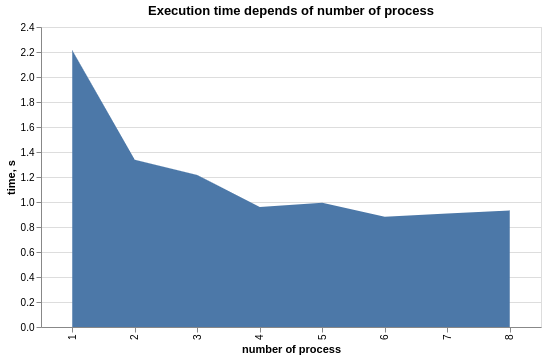

In [12]:
import altair as alt

alt.Chart(df).mark_area().encode(
    x='number of process',
    y='time, s'
).properties(
    title='Execution time depends of number of process',
    width=500,
    height=300
)

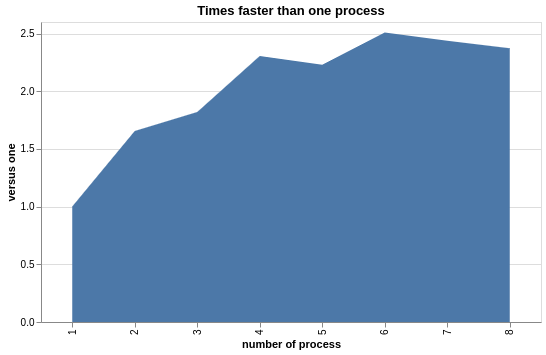

In [13]:
import altair as alt

alt.Chart(df).mark_area().encode(
    x='number of process',
    y='versus one'
).properties(
    title='Times faster than one process',
    width=500,
    height=300
)

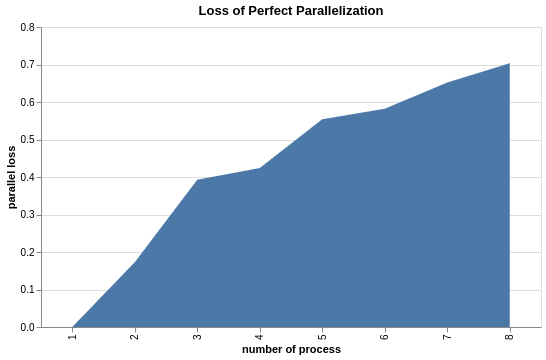

In [14]:
import altair as alt

alt.Chart(df).mark_area().encode(
    x='number of process',
    y='parallel loss'
).properties(
    title='Loss of Perfect Parallelization',
    width=500,
    height=300
)

# Numexpr

pip install numexpr

In [15]:
%%writefile numexpr_pi.py

import numexpr as ne
import numpy as np


def numexpr_pi(n_samples):
    x = np.random.ranf(n_samples)
    y = np.random.ranf(n_samples)
    return 4 * ne.evaluate("sum(where((x ** 2 + y ** 2) < 1, 1, 0))") / n_samples


Overwriting numexpr_pi.py


In [16]:
from numexpr_pi import numexpr_pi

numexpr_pi(n_samples)

3.1416646

In [17]:
import timeit

time = timeit.Timer("numexpr_pi({})".format(n_samples),
                    "from numexpr_pi import numexpr_pi")
time.timeit(n_times) / n_times

2.5284772113373037

# Numba

pip install numba

In [26]:
%%writefile numba_pi.py

from numba import njit
import numpy as np


@njit(parallel=True)
def numba_calc_pi(n_samples):
    
    x = np.random.ranf(n_samples)
    y = np.random.ranf(n_samples)
    return 4 * np.sum(x ** 2 + y ** 2 < 1) / n_samples


Overwriting numba_pi.py


In [19]:
from numba_pi import numba_calc_pi

numba_calc_pi(n_samples)

3.1419246

In [20]:
import timeit

time = timeit.Timer("numba_calc_pi({})".format(n_samples),
                    "from numba_pi import numba_calc_pi")
time.timeit(n_times) / n_times

0.35298084500633803

# Conclusion

- Numpy ~25x faster (2.2 vs 54 s) than pure python
- Joblib + numpy ~50x faster (1 vs 54 s) than pure python. Efficient up to number of phisical processors (speed up = n_phis_cores / 2)
- Numexpr ~25x faster (2.2 vs 54 s) than pure python (the same performance as numpy)
- Numba ~150x (0.35 vs 54 s) faster than pure python. Just add @njit(parallel=True) decorator!